In [1]:
import pathlib
from functools import partial

import astropy.table as at
import astropy.units as u
import cmasher as cmr
import gala.integrate as gi
import gala.potential as gp
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from astropy.convolution import Gaussian2DKernel, convolve
from gala.units import galactic
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic_2d

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import torusimaging as oti
from config import mgfe_cbar_vlim, mgfe_cbar_xlim
from model_maker import SplineLabelModelWrapper

$$
\Phi(z) = \frac{1}{2} \, \Omega^2  \, z^2\\
E_z = \frac{1}{2} \, v_z^2 + \Phi(z)\\
J_z = E_z / \Omega
$$

First, figure out $E_z$ and $J_z$ for $z_{\rm max} = 1$:

In [2]:
Omega = 0.08 * u.rad / u.Myr

scale_vz = 50 * u.km / u.s
sz = (scale_vz / np.sqrt(Omega)).decompose(galactic)  # .value

In [3]:
gala_pot = gp.HarmonicOscillatorPotential(Omega / u.rad, units=galactic)

In [4]:
N = 2**18

rng = np.random.default_rng(42)
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    Jzs = (rng.exponential(scale=sz.value**2, size=N) * sz.unit**2).to(
        galactic["length"] ** 2 / galactic["time"]
    )
    thzs = rng.uniform(0, 2 * np.pi, size=N)

In [5]:
sim_mgfe_std = 0.05

with u.set_enabled_equivalencies(u.dimensionless_angles()):
    pdata = {
        "z": (np.sqrt(2 * Jzs / Omega) * np.sin(thzs)).to(galactic["length"]),
        "vz": (np.sqrt(2 * Jzs * Omega) * np.cos(thzs)).to(
            galactic["length"] / galactic["time"]
        ),
        "Jz": Jzs,
        "thetaz": thzs,
        "zmax": np.sqrt(2 * Jzs / Omega).to_value(galactic["length"]),
    }
    pdata["r_e"] = np.sqrt(pdata["z"] ** 2 * Omega + pdata["vz"] ** 2 / Omega)
    pdata["mgfe"] = rng.normal(0.064 * pdata["zmax"] + 0.009, sim_mgfe_std)

In [6]:
oti_data = oti.OTIData(pos=pdata["z"], vel=pdata["vz"], labels=dict(mgfe=pdata["mgfe"]))

In [7]:
max_re = (5 * scale_vz / np.sqrt(Omega)).decompose(galactic)
max_re.value

0.9039583838822332

In [8]:
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    max_z = (max_re / np.sqrt(Omega)).to(galactic["length"])
    max_vz = (max_re * np.sqrt(Omega)).to(galactic["velocity"])

max_z = np.round(max_z, 0)
max_vz = np.round(max_vz, 0)
max_z, max_vz

(<Quantity 3. kpc>, <Quantity 250. km / s>)

In [9]:
zbins = np.linspace(-max_z.value, max_z.value, 151)
zvz_bins = {"pos": zbins, "vel": Omega * zbins}

counts = oti_data.get_binned_counts(zvz_bins)
bdata, _ = oti_data.get_binned_label(bins=zvz_bins)
bdata["mgfe_err"] = sim_mgfe_std / np.sqrt(counts["counts"])

/tmp/ipykernel_1826275/779631902.py:6: RuntimeWarning: divide by zero encountered in true_divide
  bdata["mgfe_err"] = sim_mgfe_std / np.sqrt(counts["counts"])


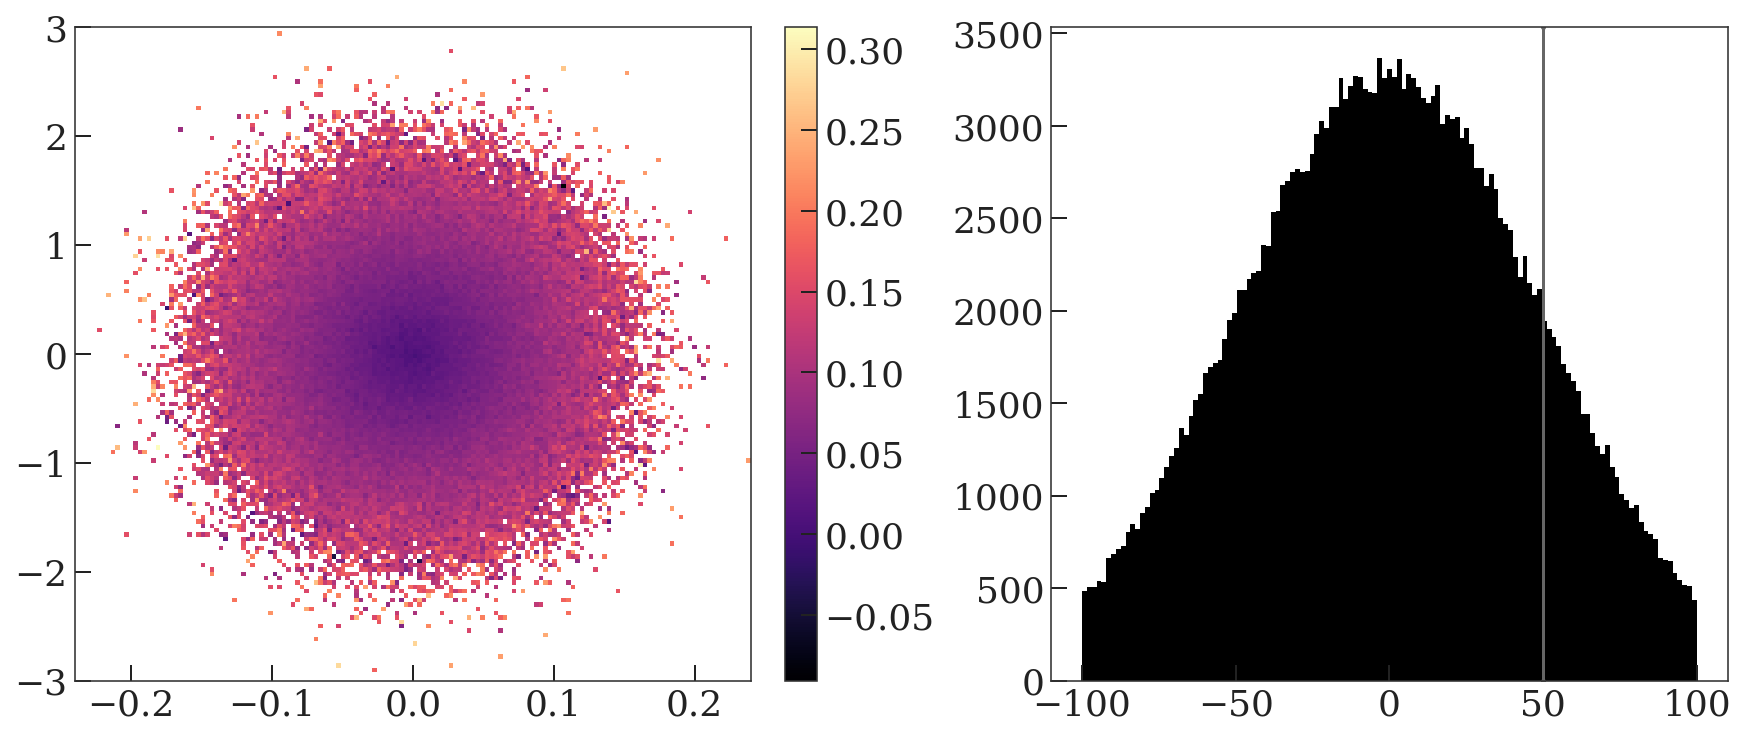

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
cs = axes[0].pcolormesh(bdata["vel"].value, bdata["pos"].value, bdata["mgfe"])
fig.colorbar(cs, ax=axes[0])
axes[1].hist(oti_data.vel.to_value(u.km / u.s), bins=np.linspace(-100, 100, 128))
axes[1].axvline(scale_vz.value)

In [11]:
model = SplineLabelModelWrapper(
    r_e_max=max_re.value,
    label_n_knots=10,
    label0_bounds=(-1.0, 1.0),
    label_grad_sign=1.0,
    label_regularize_sigma=1.0,
    label_smooth_sigma=0.2,
    e_n_knots={2: 5},  # , 4: 3}
    e_regularize_sigmas={2: 0.1},
    e_smooth_sigmas={2: 0.2},
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [12]:
p0 = model.get_init_params(oti_data)
p0

{'pos0': 0.0022067129262578495,
 'vel0': -9.850438399861564e-05,
 'ln_Omega0': -2.5332713785892333,
 'e_params': {2: {'vals': Array([-10, -10, -10, -10], dtype=int64, weak_type=True)}},
 'label_params': {'label_vals': array([0.02114444, 0.30011139, 0.30011139, 0.30011139, 0.30011139,
         0.30011139, 0.30011139, 0.30011139, 0.30011139, 0.30011139])}}

In [13]:
_, res = model.run(bdata, p0=p0, bins=zvz_bins, label_name="mgfe")
res.state.success, res.state.iter_num

(True, 1313)

In [14]:
res.params

{'e_params': {2: {'vals': Array([-10.0000489 , -10.00003436, -10.00001968, -10.00001131], dtype=float64)}},
 'label_params': {'label_vals': Array([0.00846269, 0.23086666, 0.22417244, 0.23018562, 0.21236597,
         0.24518273, 0.19674693, 0.22573877, 0.25748294, 0.26468062],      dtype=float64)},
 'ln_Omega0': Array(-2.52223104, dtype=float64),
 'pos0': Array(-0.00222777, dtype=float64),
 'vel0': Array(-5.36285673e-05, dtype=float64)}

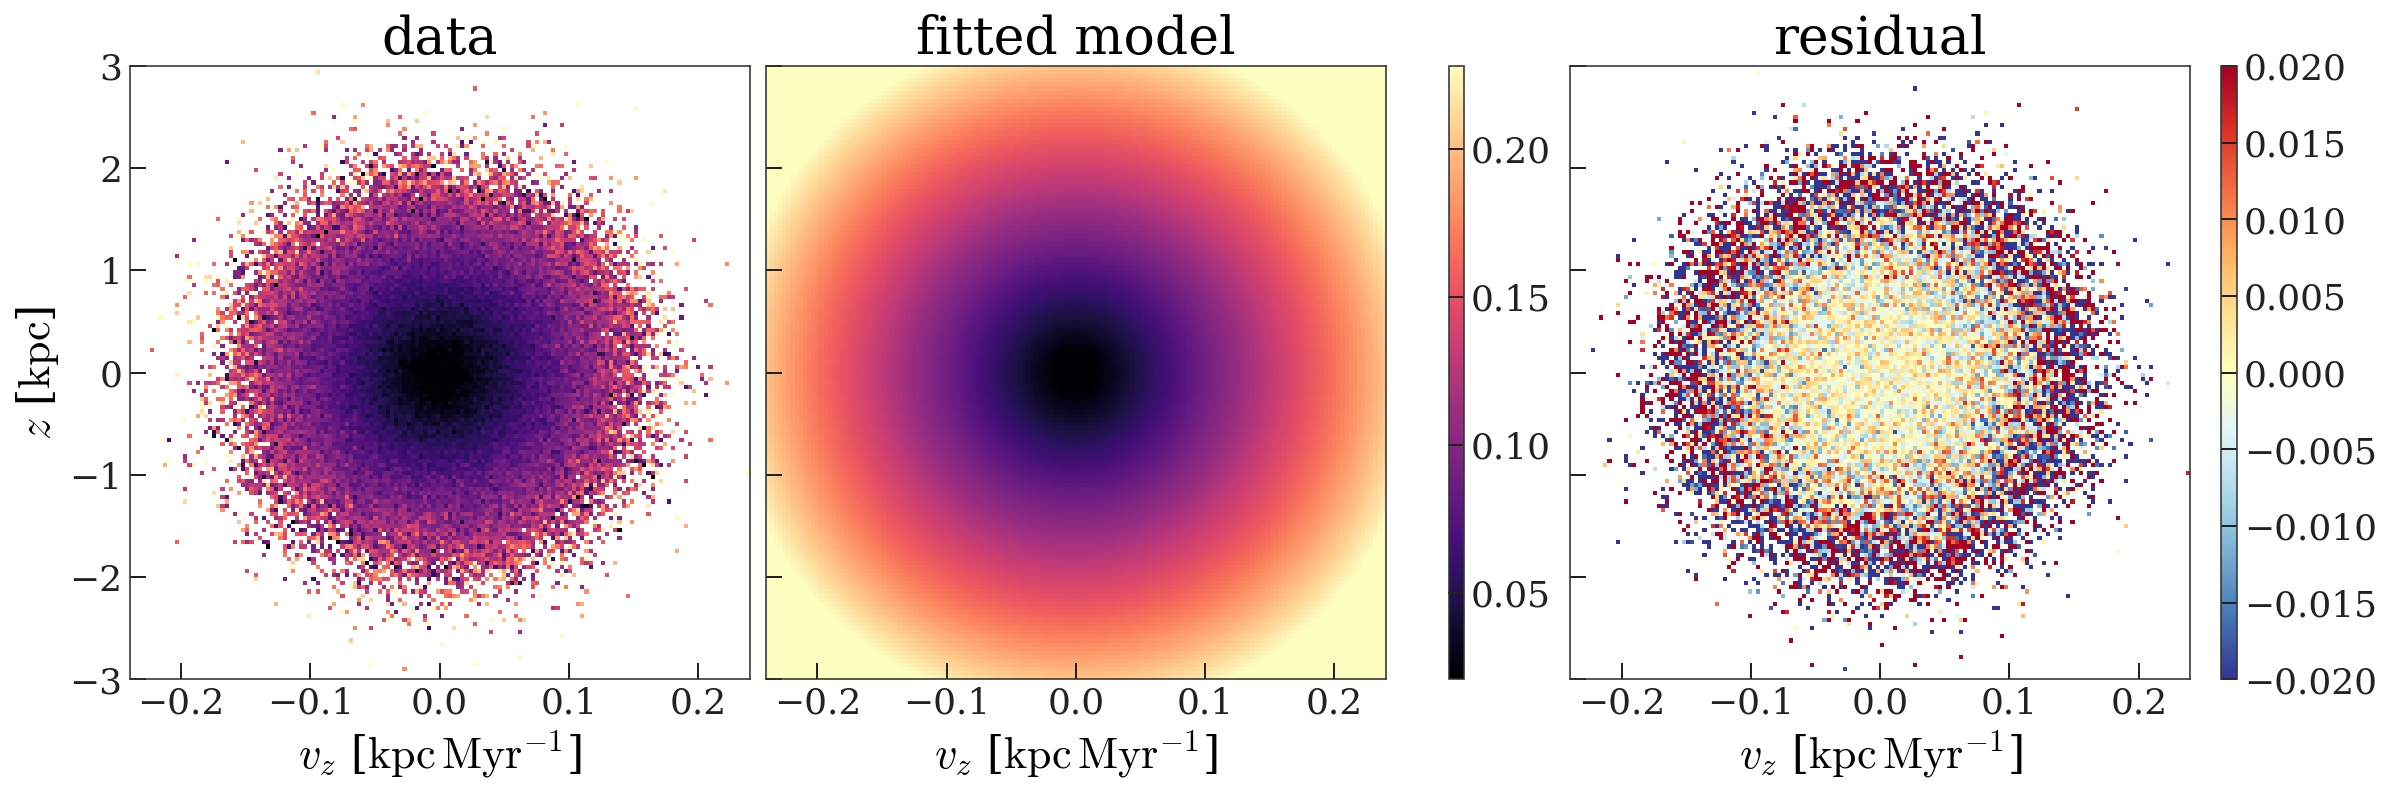

In [15]:
fig, axes = oti.plot.plot_data_models_residual(
    bdata,
    model.label_model,
    res.params,
    label_name="mgfe",
    fractional_residual=False,
    vlim_residual=0.02,
)

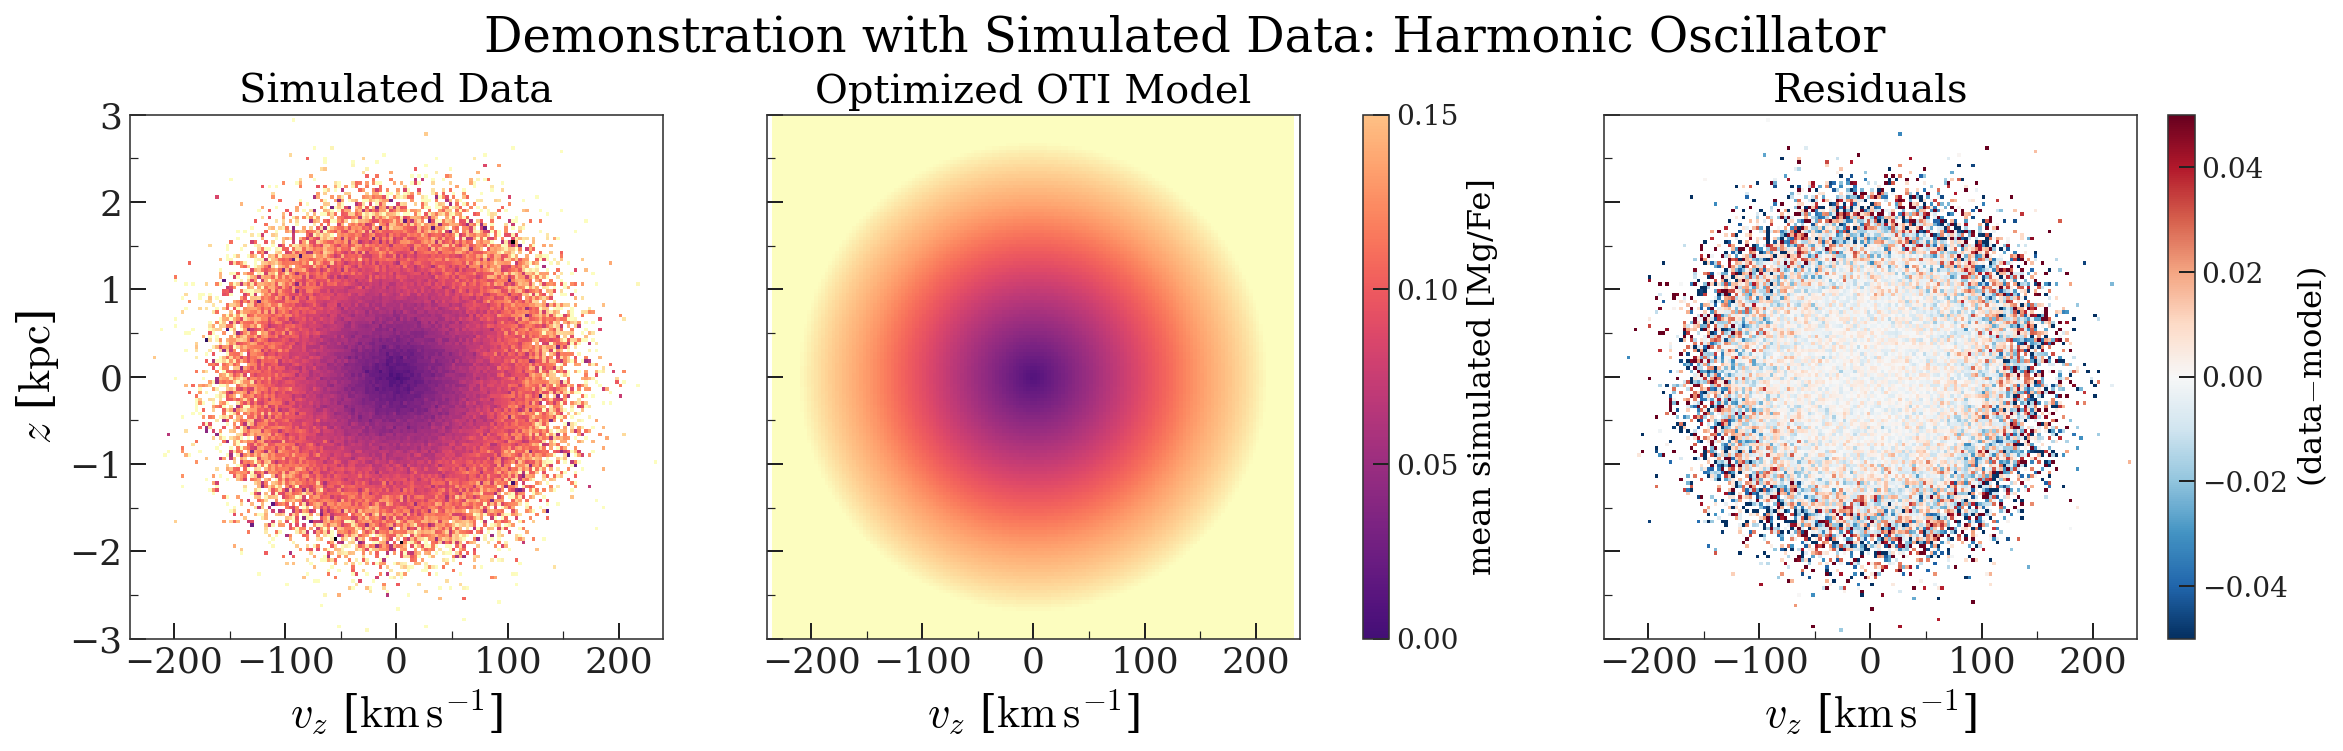

In [46]:
cb_labelsize = 16

fig, axes = plt.subplots(
    1, 3, figsize=(16, 5.1), sharex=True, sharey=True, layout="constrained"
)

cs = axes[0].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    bdata["mgfe"],
    cmap="magma",
    rasterized=True,
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
cb = fig.colorbar(cs, ax=axes[0:2])  # , orientation="horizontal", aspect=40)
cb.set_label("mean simulated [Mg/Fe]", fontsize=cb_labelsize)
cb.ax.set_ylim(mgfe_cbar_xlim)
cb.ax.set_yticks(np.arange(mgfe_cbar_xlim[0], mgfe_cbar_xlim[1] + 1e-3, 0.05))
cb.ax.yaxis.set_tick_params(labelsize=14)


model_mgfe = np.array(model.label_model.label(bdata["pos"], bdata["vel"], res.params))
cs = axes[1].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    model_mgfe,
    cmap="magma",
    rasterized=True,
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
# cb = fig.colorbar(cs, ax=axes[1], orientation="horizontal")
# cb.set_label("number density", fontsize=cb_labelsize)

cs = axes[2].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    bdata["mgfe"] - model_mgfe,
    cmap="RdBu_r",
    vmin=-0.05,
    vmax=0.05,
    rasterized=True,
)
cb = fig.colorbar(cs, ax=axes[2])  # , orientation="horizontal")
cb.set_label("(data$-$model)", fontsize=cb_labelsize)
cb.ax.yaxis.set_tick_params(labelsize=14)

# Titles
axes[0].set_title("Simulated Data", fontsize=20)
axes[1].set_title("Optimized OTI Model", fontsize=20)
axes[2].set_title("Residuals", fontsize=20)
fig.suptitle("Demonstration with Simulated Data: Harmonic Oscillator", fontsize=24)

# Labels
axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")
for ax in axes:
    ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")

# Ticks
zlim = (-3, 3)
vzlim = (-240, 240)
axes[0].set_xticks(np.arange(-200, 200 + 1, 100))
axes[0].set_xticks(np.arange(-200, 200 + 1, 50), minor=True)
axes[1].set_yticks(np.arange(-3, 3 + 1e-3, 1))
axes[1].set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

for ax in axes:
    ax.set_aspect(2 * np.pi / Omega.value)
    ax.set_xlim(vzlim)
    ax.set_ylim(zlim)

fig.savefig(
    "../tex/figures/sho-data-model.pdf", dpi=250, pad_inches=0.1, bbox_inches="tight"
)

In [17]:
res.params

{'e_params': {2: {'vals': Array([-10.0000489 , -10.00003436, -10.00001968, -10.00001131], dtype=float64)}},
 'label_params': {'label_vals': Array([0.00846269, 0.23086666, 0.22417244, 0.23018562, 0.21236597,
         0.24518273, 0.19674693, 0.22573877, 0.25748294, 0.26468062],      dtype=float64)},
 'ln_Omega0': Array(-2.52223104, dtype=float64),
 'pos0': Array(-0.00222777, dtype=float64),
 'vel0': Array(-5.36285673e-05, dtype=float64)}

In [18]:
# tmp_data = bdata.copy()
# tmp_data["label"] = tmp_data.pop("mgfe")
# tmp_data["label_err"] = tmp_data.pop("mgfe_err")
# mask = np.logical_and.reduce([np.isfinite(tmp_data[k]) for k in tmp_data])
# tmp_data = {k: tmp_data[k][mask] for k in tmp_data}

# errs = model.label_model.error_propagate_uncertainty(res.params, tmp_data)
# errs

In [19]:
# Minv = model.label_model.get_crlb(res.params, tmp_data, inv=True)
# M = np.linalg.inv(Minv)

# fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")

# cs = axes[0].imshow(
#     Minv, norm=mpl.colors.SymLogNorm(1e-8, vmin=-1e8, vmax=1e8), cmap="RdBu"
# )
# cb = fig.colorbar(cs, ax=axes[0])
# axes[0].set_title("fisher")

# cs = axes[1].imshow(
#     M, norm=mpl.colors.SymLogNorm(1e-8, vmin=-1e0, vmax=1e0), cmap="RdBu"
# )
# cb = fig.colorbar(cs, ax=axes[1])
# axes[1].set_title("cov")

In [20]:
states, mcmc_samples = model.run_mcmc(bdata, p0=res.params, label_name="mgfe")

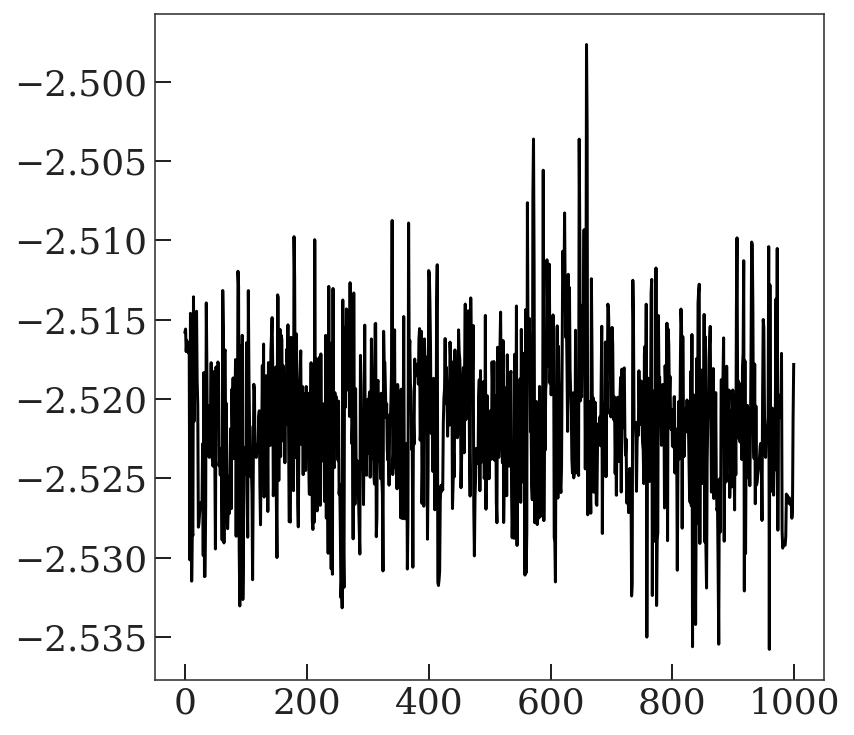

In [21]:
plt.plot(states.position["ln_Omega0"], marker="")

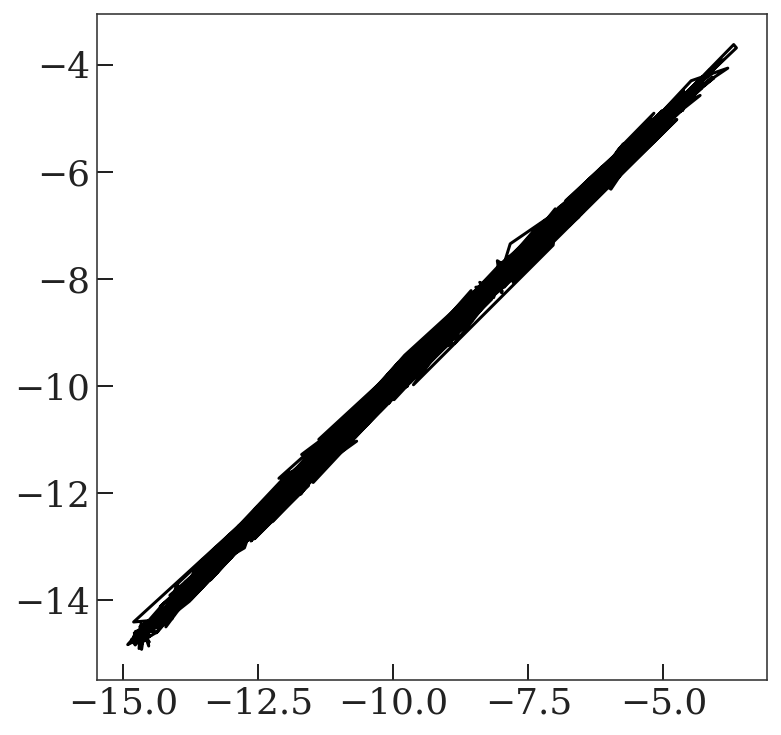

In [22]:
plt.plot(
    states.position["e_params"][2]["vals"][:, 0],
    states.position["e_params"][2]["vals"][:, 1],
    marker="",
)

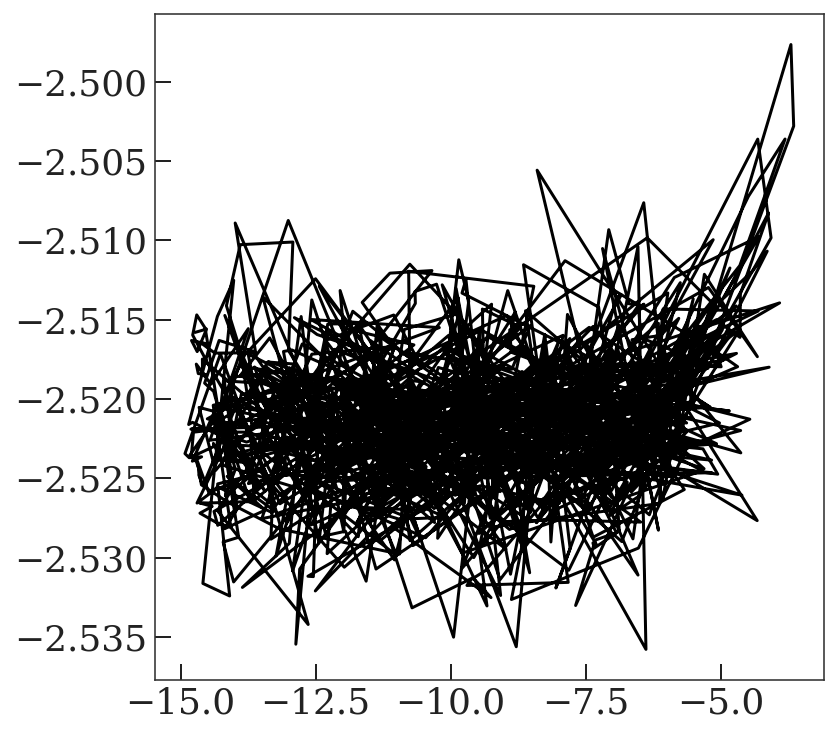

In [23]:
plt.plot(
    states.position["e_params"][2]["vals"][:, 0],
    states.position["ln_Omega0"],
    marker="",
)

In [24]:
accs = []
grid = np.linspace(-3, 3, 512) * u.kpc
for p in mcmc_samples:
    acc = model.label_model.get_acceleration(grid, p)
    accs.append(acc.value)
accs = accs * acc.unit

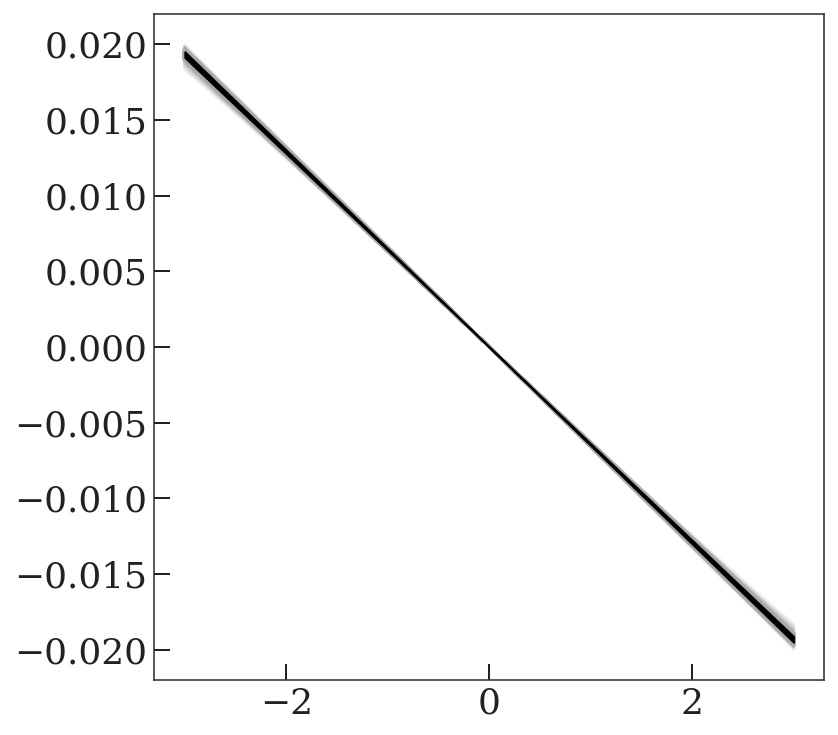

In [25]:
plt.plot(grid, accs.T, marker="", alpha=0.1, color="#aaaaaa")

p1, p2 = np.nanpercentile(accs.value, [16, 84], axis=0)
plt.fill_between(grid.value, p1, p2, color="k", zorder=10)

Estimate error with Fisher crap

In [26]:
# Nsamples = 1024
# par_samples = model.label_model.get_crlb_error_samples(res.params, tmp_data, size=Nsamples, list_of_samples=False)

# rng = np.random.default_rng(seed=42)
# par_samples['e_params'][2]['vals'] = rng.normal(res.params['e_params'][2]['vals'], np.log(errs['e_params'][2]['vals']),
#                                                 size=par_samples['e_params'][2]['vals'].shape)

# treedef = jax.tree_util.tree_structure(res.params)
# tmp, _ = jax.tree_util.tree_flatten(par_samples)
# par_samples = [jax.tree_util.tree_unflatten(treedef, [tmp[i][n] for i in range(len(tmp))]) for n in range(Nsamples)]

In [27]:
# accs = []
# grid = np.linspace(-3, 3, 512) * u.kpc
# for p in par_samples:
#     acc = model.label_model.get_acceleration(grid, p)
#     accs.append(acc.value)
# accs = accs * acc.unit

In [28]:
a_unit = u.km / u.s / u.Myr
true_acc = (-(Omega**2) * grid).to_value(a_unit, u.dimensionless_angles())
acc = accs.to_value(a_unit)
dacc = acc.T - true_acc[:, None]

In [29]:
bestfit_acc = model.label_model.get_acceleration(grid, res.params).to_value(a_unit)

In [30]:
aaf = model.label_model.compute_action_angle(pdata["z"], pdata["vz"], res.params)

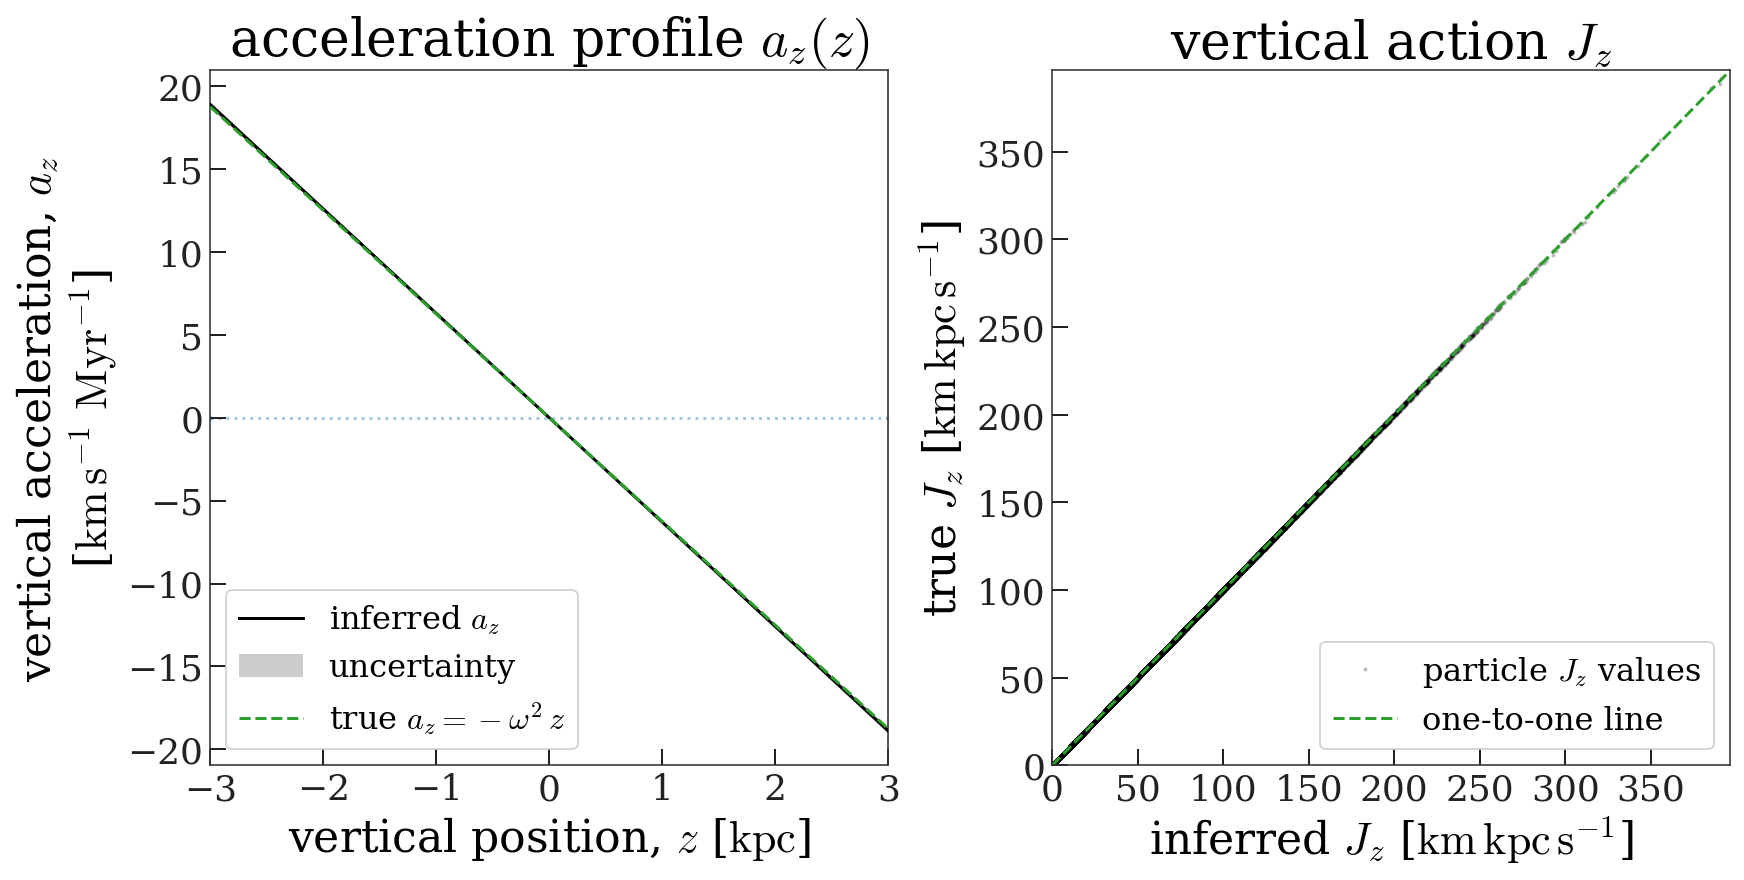

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6.0), layout="constrained")

ax = axes[0]
ax.plot(
    grid.value,
    bestfit_acc,
    color="k",
    marker="",
    label="inferred $a_z$",
    zorder=10,
)
ax.fill_between(
    grid.value,
    np.nanpercentile(acc, 16, axis=0),
    np.nanpercentile(acc, 84, axis=0),
    color="#cccccc",
    lw=0,
    label=r"uncertainty",
    zorder=2,
)
ax.plot(
    grid.value,
    true_acc,
    ls="--",
    color="tab:green",
    marker="",
    label=r"true $a_z=-\omega^2\,z$",
    zorder=15,
)
ax.set_xlim(grid.value.min(), grid.value.max())
ax.axhline(0, zorder=-10, color="tab:blue", alpha=0.4, ls=":")
ax.legend(loc="lower left", fontsize=16)

ax.set_xlabel(f"vertical position, $z$ [{u.kpc:latex}]")
ax.set_ylabel(
    f"vertical acceleration, $a_z$\n[{u.km/u.s:latex_inline} {u.Myr**-1:latex_inline}]"
)
ax.set_title("acceleration profile $a_z(z)$")

ax = axes[1]
Junit = u.km / u.s * u.kpc
ax.plot(
    aaf["J"].to_value(Junit),
    pdata["Jz"].to_value(Junit),
    marker="o",
    ls="none",
    alpha=0.25,
    mew=0,
    ms=2.0,
    label="particle $J_z$ values",
    rasterized=True,
)
ax.axline(
    [0, 0],
    [pdata["Jz"].to_value(Junit).max(), pdata["Jz"].to_value(Junit).max()],
    ls="--",
    color="tab:green",
    marker="",
    label="one-to-one line",
)
ax.set_xlim(0, pdata["Jz"].to_value(Junit).max())
ax.set_ylim(0, pdata["Jz"].to_value(Junit).max())
ax.set_title("vertical action $J_z$")

ax.legend(loc="lower right", fontsize=16)

ax.set_xlabel(f"inferred $J_z$ [{Junit:latex_inline}]")
ax.set_ylabel(f"true $J_z$ [{Junit:latex_inline}]")
ax.set_xticks(np.arange(0, 400, 50))
ax.set_yticks(np.arange(0, 400, 50))

# OLD 2 PANEL VERSION
# fig.savefig("../tex/figures/sho-validation.pdf", dpi=250)

In [32]:
get_pos_vec = jax.vmap(model.label_model.get_pos, in_axes=[None, 0, None])
get_vel_vec = jax.vmap(model.label_model.get_vel, in_axes=[None, 0, None])

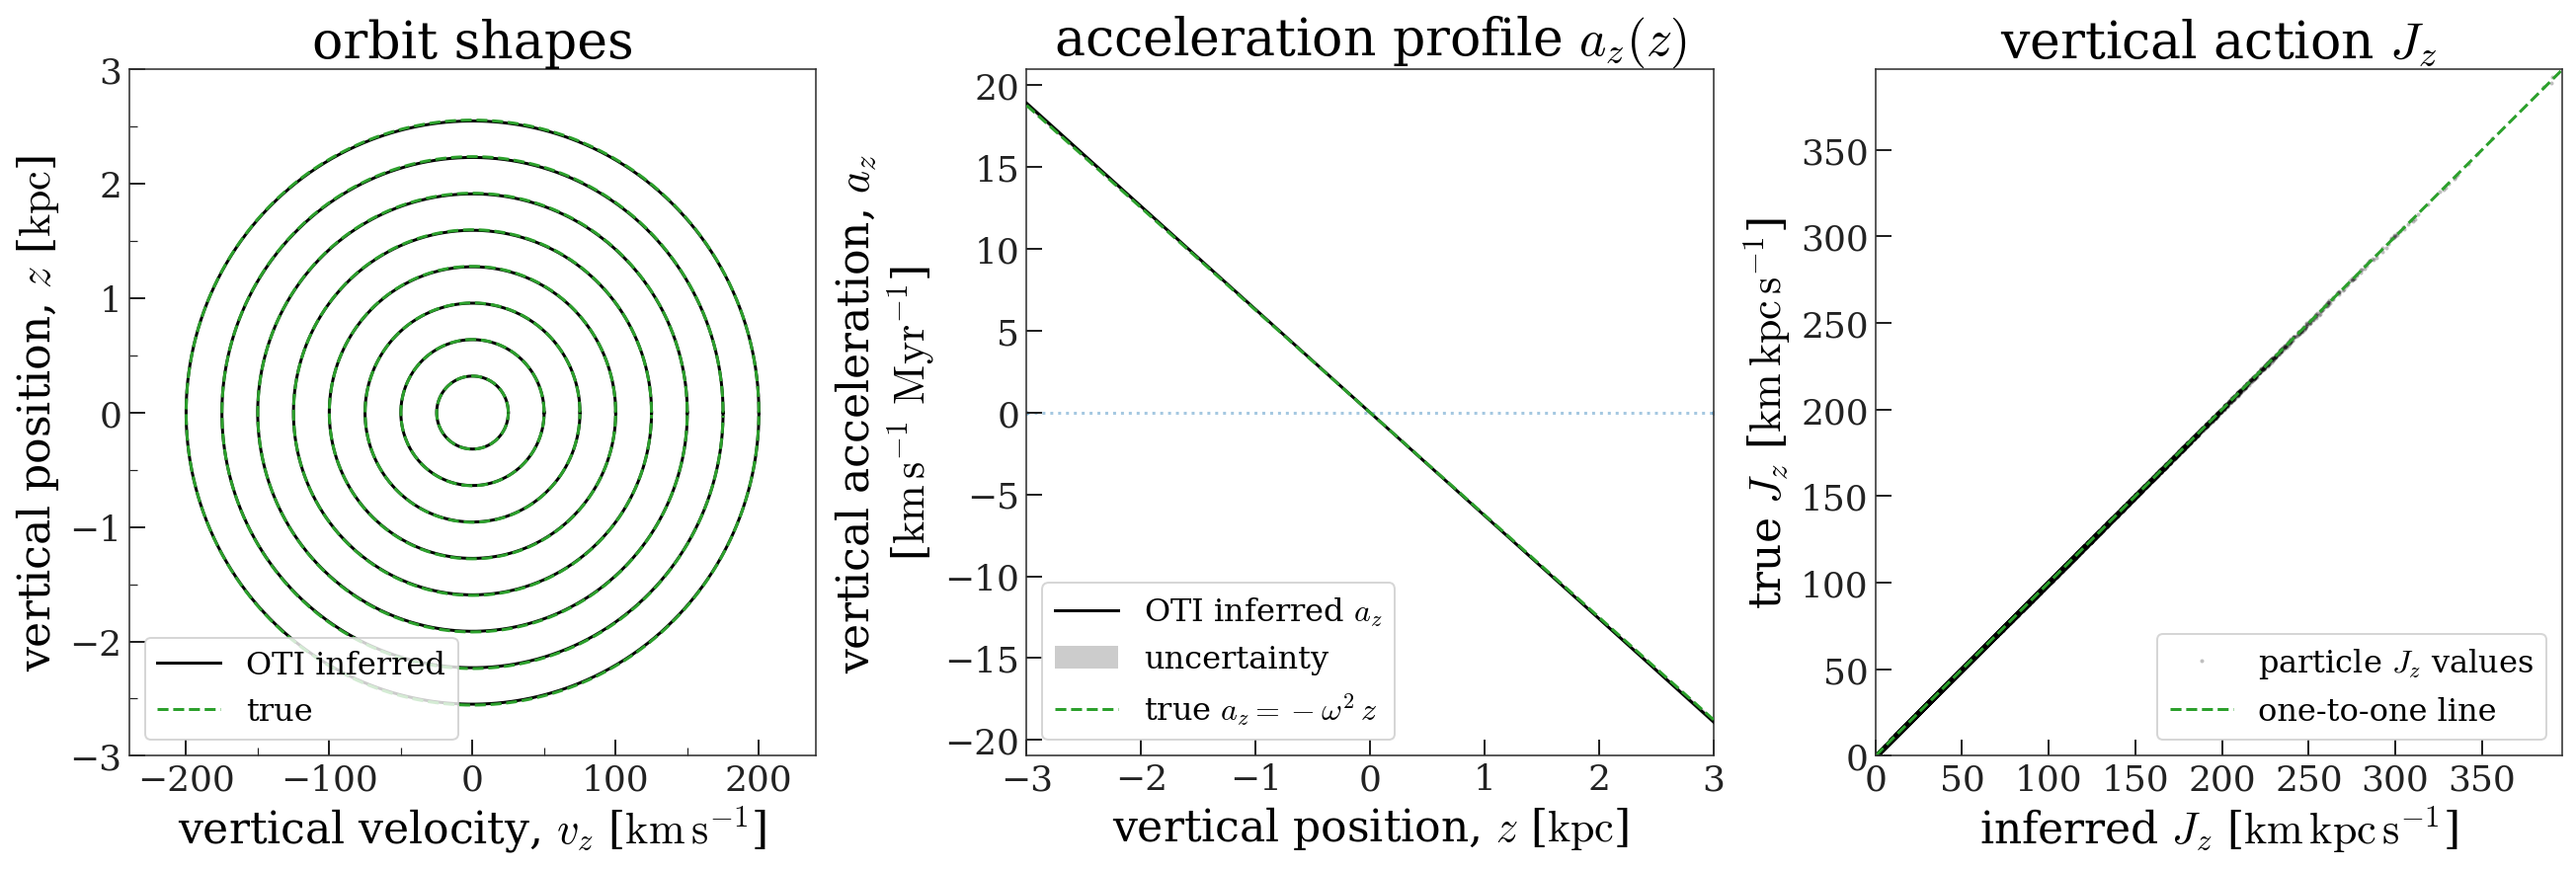

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6.0), layout="constrained")

ax = axes[0]
th_e_grid = np.linspace(0, 2 * np.pi, 1024)
orbit_vzs = np.linspace(0, 1.0, 8 + 1)[1:] * max_vz * 0.8

T = 2 * np.pi / Omega.value
dt = T / 512

for i, vv in enumerate(orbit_vzs.decompose(galactic).value):
    rr = model.label_model.get_r(
        *model.label_model.get_elliptical_coords(0.0, vv, res.params),
        res.params["e_params"],
    )

    oti_pp = get_pos_vec(rr, th_e_grid, res.params)
    oti_vv = (get_vel_vec(rr, th_e_grid, res.params) * u.kpc / u.Myr).to_value(
        u.km / u.s
    )
    if i == 0:
        kw = dict(label="OTI inferred")
    else:
        kw = {}
    ax.plot(oti_vv, oti_pp, marker="", ls="-", color="k", zorder=4, **kw)

    orbit = gala_pot.integrate_orbit(
        [0.0, vv], dt=dt, t1=0, t2=T, Integrator=gi.DOPRI853Integrator
    )
    true_pp = orbit.x1.value
    true_vv = orbit.v_x1.to_value(u.km / u.s)
    if i == 0:
        kw = dict(label="true")
    else:
        kw = {}
    ax.plot(true_vv, true_pp, marker="", color="tab:green", ls="--", zorder=10, **kw)

# Labels
ax.set_ylabel(f"vertical position, $z$ [{u.kpc:latex_inline}]")
ax.set_xlabel(f"vertical velocity, $v_z$ [{u.km/u.s:latex_inline}]")

# Ticks
ax.set_xticks(np.arange(-200, 200 + 1, 100))
ax.set_xticks(np.arange(-200, 200 + 1, 50), minor=True)
ax.set_yticks(np.arange(-3, 3 + 1e-3, 1))
ax.set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)
ax.set_xlim(vzlim)
ax.set_ylim(zlim)
ax.set_title("orbit shapes")
ax.legend(loc="lower left", fontsize=16).set_zorder(10)

# -----------------------------------------------------------------------
ax = axes[1]
ax.plot(
    grid.value,
    bestfit_acc,
    color="k",
    marker="",
    label="OTI inferred $a_z$",
    zorder=10,
)
ax.fill_between(
    grid.value,
    np.nanpercentile(acc, 16, axis=0),
    np.nanpercentile(acc, 84, axis=0),
    color="#cccccc",
    lw=0,
    label=r"uncertainty",
    zorder=2,
)
ax.plot(
    grid.value,
    true_acc,
    ls="--",
    color="tab:green",
    marker="",
    label=r"true $a_z=-\omega^2\,z$",
    zorder=15,
)
ax.set_xlim(zlim)
ax.axhline(0, zorder=-10, color="tab:blue", alpha=0.4, ls=":")
ax.legend(loc="lower left", fontsize=16)

ax.set_xlabel(f"vertical position, $z$ [{u.kpc:latex}]")
ax.set_ylabel(
    f"vertical acceleration, $a_z$\n[{u.km/u.s:latex_inline} {u.Myr**-1:latex_inline}]"
)
ax.set_title("acceleration profile $a_z(z)$")

# -----------------------------------------------------------------------
ax = axes[2]
Junit = u.km / u.s * u.kpc
ax.plot(
    aaf["J"].to_value(Junit),
    pdata["Jz"].to_value(Junit),
    marker="o",
    ls="none",
    alpha=0.25,
    mew=0,
    ms=2.0,
    label="particle $J_z$ values",
    rasterized=True,
)
ax.axline(
    [0, 0],
    [pdata["Jz"].to_value(Junit).max(), pdata["Jz"].to_value(Junit).max()],
    ls="--",
    color="tab:green",
    marker="",
    label="one-to-one line",
)
ax.set_xlim(0, pdata["Jz"].to_value(Junit).max())
ax.set_ylim(0, pdata["Jz"].to_value(Junit).max())
ax.set_title("vertical action $J_z$")

ax.legend(loc="lower right", fontsize=16)

ax.set_xlabel(f"inferred $J_z$ [{Junit:latex_inline}]")
ax.set_ylabel(f"true $J_z$ [{Junit:latex_inline}]")
ax.set_xticks(np.arange(0, 400, 50))
ax.set_yticks(np.arange(0, 400, 50))

fig.savefig("../tex/figures/sho-validation.pdf", dpi=250)

In [40]:
idx = np.abs(grid - 2 * u.kpc).argmin()
frac_dacc = dacc / true_acc[:, None]
np.diff(np.nanpercentile(frac_dacc[idx], [16, 84])) / 2

array([0.00931397])

In [41]:
frac_diff = (aaf["J"].to_value(Junit) - pdata["Jz"].to_value(Junit)) / pdata[
    "Jz"
].to_value(Junit)
np.median(np.abs(frac_diff))

0.004340810651488886